In [11]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [12]:
# main functions to import from src
from src import GGB_Statements, get_model_shortname, ring_csv_to_df, ring_to_roundrobin_df

from visualization_functions import plot_by_question, human_kde, h2, plot_IH_v_IB

In [13]:
# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/OUS.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/OUSinverted.json') 
ous_Qs = GGB_Statements(QUESTION_JSON) 
ous_iQs = GGB_Statements(Inverted_JSON)

In [14]:
ous_ring_csvs = glob.glob('results_ous_multi/**_ensemble_**_q1-9_n5.csv')

In [15]:
ring_rr_df = pd.DataFrame()

for csv_file in ous_ring_csvs:
    if 'inverted' in csv_file:
        current_Qs = ous_iQs
    else:
        current_Qs = ous_Qs
    
    df = ring_csv_to_df(csv_file, current_Qs)
    rr_df = ring_to_roundrobin_df(df, current_Qs)
    ring_rr_df = pd.concat([ring_rr_df, rr_df], ignore_index=True)

# add the ous question number:
ring_rr_df['ous_question_id'] = ring_rr_df['question_id'].apply(lambda x: x % 100)

In [16]:
ring_by_question = ring_rr_df.groupby(['chat_type', 'question_id','question_num','category', 'ous_question_id', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ring_by_category = ring_rr_df.groupby(['chat_type', 'category', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_12528/1006337740.py:2: RuntimeWarning: Mean of empty slice
  ('mean', lambda x: np.nanmean(x)),
/Users/oshun/Documents/GitHub/wisdom_agents/.conda/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,chat_type,question_id,question_num,category,ous_question_id,round,mean,std,sem
3,ous_claude_ring,201,2,IH,1,4,1.4,0.547723,0.244949
7,ous_claude_ring,202,4,IH,2,4,1.2,0.447214,0.200000
11,ous_claude_ring,203,6,IH,3,4,1.4,0.547723,0.244949
15,ous_claude_ring,204,8,IH,4,4,1.2,0.447214,0.200000
19,ous_claude_ring,205,1,IB,5,4,4.6,0.547723,0.244949
...,...,...,...,...,...,...,...,...,...
487,ous_qwen_ring,205,1,IB,5,4,6.2,0.447214,0.200000
491,ous_qwen_ring,206,3,IB,6,4,5.0,0.000000,0.000000
495,ous_qwen_ring,207,5,IB,7,4,6.4,0.894427,0.400000
499,ous_qwen_ring,208,7,IB,8,4,6.0,0.707107,0.316228


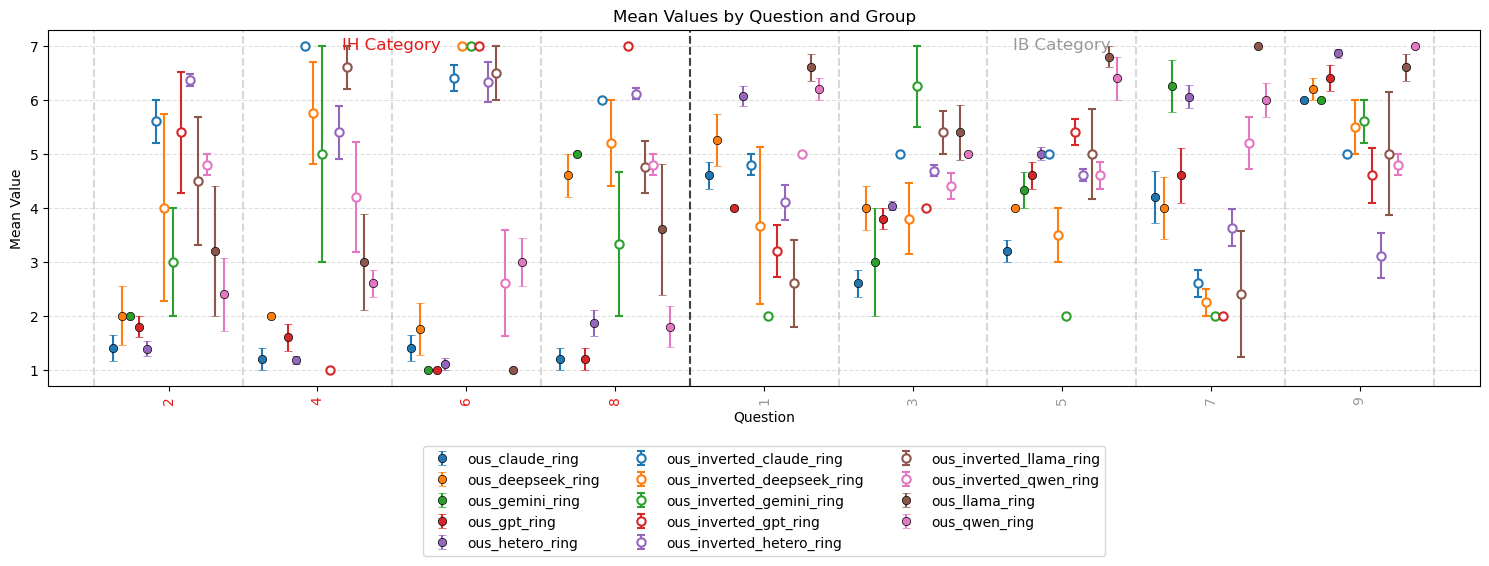

In [20]:
f = plot_by_question(data = ring_by_question[ring_by_question['round'] == 4], group_by = 'chat_type', category_order=['IH','IB'], 
    match_inverted_colors=True,
    inverted_indicator='inverted', error_col= 'sem')

ax = f.axes[0]  # Get the axes from the figure
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()  # Adjust layout to accommodate the legend

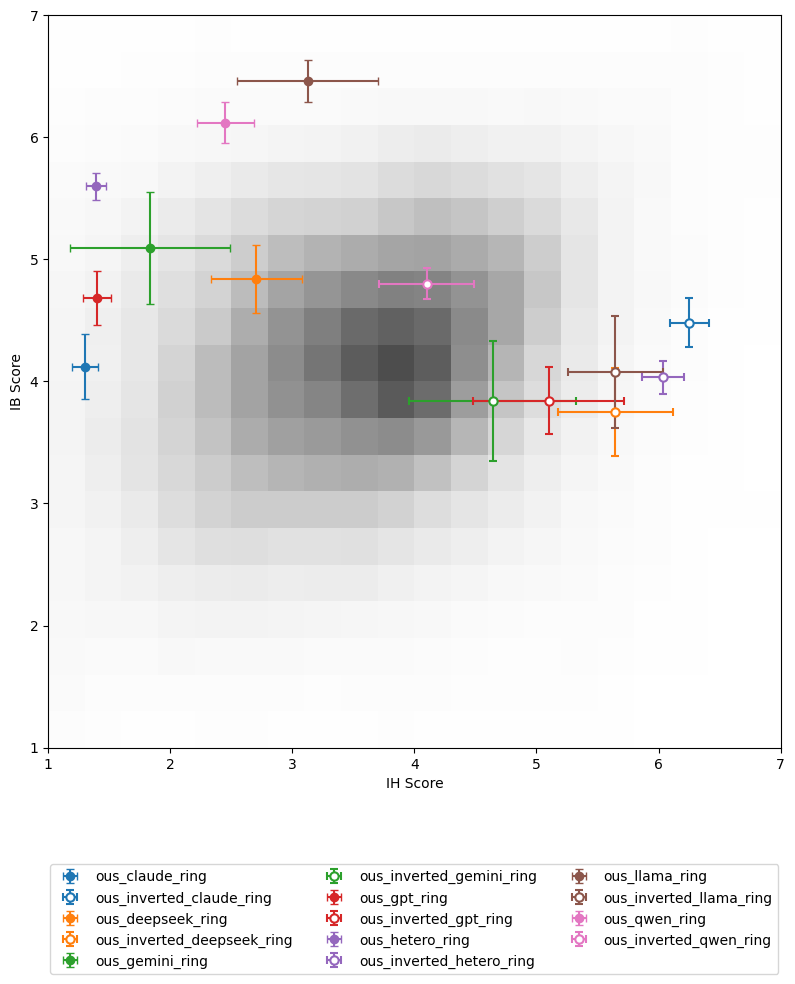

In [19]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = False)

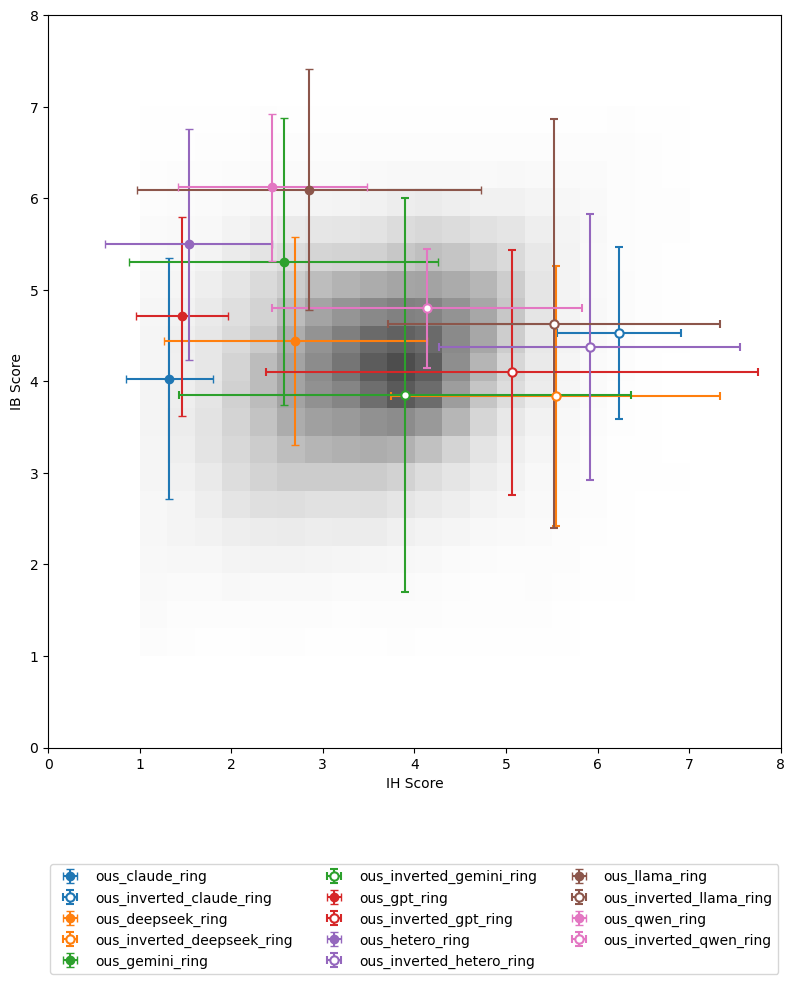

In [9]:
f = plot_IH_v_IB (ring_by_category, use_std = True,ax_lims=[0,8])